In [1]:
import sqlite3
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# db files
disk_db_file = "./sample_data/disk/database.db"
colmap_sift_db_file = "./sample_data/colmap/database.db"
merged_db_file = "./sample_data/merged_database.db"

In [3]:
# connection
disk_conn = sqlite3.connect(disk_db_file)
colmap_sift_conn = sqlite3.connect(colmap_sift_db_file)
merged_conn = sqlite3.connect(merged_db_file)

# cursor
disk_cursor = disk_conn.cursor()
colmap_sift_cursor = colmap_sift_conn.cursor()
merged_cursor = merged_conn.cursor()

In [4]:
MAX_IMAGE_ID = 2**31 - 1


def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % MAX_IMAGE_ID
    image_id1 = (pair_id - image_id2) / MAX_IMAGE_ID
    return image_id1, image_id2


def blob_to_array(blob, dtype, shape=(-1,)):
    if blob is None:
        return []
    return np.frombuffer(blob, dtype=dtype).reshape(*shape)

# **IMAGES TABLE VALIDATION**

In [5]:
# function to get image ids to image names
def get_image_ids_to_image_names(cursor):
    cursor.execute("SELECT image_id, name FROM images;")
    image_ids_to_image_names = {}
    for row in cursor.fetchall():
        image_ids_to_image_names[row[0]] = row[1]
    return image_ids_to_image_names


# get image ids to image names
disk_image_ids_to_image_names = get_image_ids_to_image_names(disk_cursor)
colmap_sift_image_ids_to_image_names = get_image_ids_to_image_names(colmap_sift_cursor)
merged_image_ids_to_image_names = get_image_ids_to_image_names(merged_cursor)

print(disk_image_ids_to_image_names)
print(colmap_sift_image_ids_to_image_names)
print(merged_image_ids_to_image_names)
disk_image_ids_to_image_names==colmap_sift_image_ids_to_image_names==merged_image_ids_to_image_names

{1: '0.jpg', 2: '1.jpg', 3: '10.jpg', 4: '11.jpg', 5: '12.jpg', 6: '13.jpg', 7: '14.jpg', 8: '15.jpg', 9: '16.jpg', 10: '17.jpg', 11: '18.jpg', 12: '19.jpg', 13: '2.jpg', 14: '20.jpg', 15: '21.jpg', 16: '22.jpg', 17: '3.jpg', 18: '4.jpg', 19: '5.jpg', 20: '6.jpg', 21: '7.jpg', 22: '8.jpg', 23: '9.jpg'}
{1: '0.jpg', 2: '1.jpg', 3: '10.jpg', 4: '11.jpg', 5: '12.jpg', 6: '13.jpg', 7: '14.jpg', 8: '15.jpg', 9: '16.jpg', 10: '17.jpg', 11: '18.jpg', 12: '19.jpg', 13: '2.jpg', 14: '20.jpg', 15: '21.jpg', 16: '22.jpg', 17: '3.jpg', 18: '4.jpg', 19: '5.jpg', 20: '6.jpg', 21: '7.jpg', 22: '8.jpg', 23: '9.jpg'}
{1: '0.jpg', 2: '1.jpg', 3: '10.jpg', 4: '11.jpg', 5: '12.jpg', 6: '13.jpg', 7: '14.jpg', 8: '15.jpg', 9: '16.jpg', 10: '17.jpg', 11: '18.jpg', 12: '19.jpg', 13: '2.jpg', 14: '20.jpg', 15: '21.jpg', 16: '22.jpg', 17: '3.jpg', 18: '4.jpg', 19: '5.jpg', 20: '6.jpg', 21: '7.jpg', 22: '8.jpg', 23: '9.jpg'}


True

# **KEYPOINT TABLE VALIDATION**

In [6]:
# function to get keypoints
def get_keypoints(cursor, method: str):
    # preprocess keypoints
    if method == "disk":
        keypoints = dict(
            (image_id, blob_to_array(data, np.float32, (-1, 2)))
            for image_id, data in cursor.execute("SELECT image_id, data FROM keypoints")
        )
    elif method == "colmap":
        keypoints = dict(
            (image_id, blob_to_array(data, np.float32, (-1, 6)))
            for image_id, data in cursor.execute("SELECT image_id, data FROM keypoints")
        )
    return keypoints

In [7]:
colmap_keypoints = get_keypoints(colmap_sift_cursor, method="colmap")
disk_keypoints = get_keypoints(disk_cursor, method="disk")
merged_keypoints = get_keypoints(merged_cursor, method="disk")

In [8]:
image_id = 21
colmap_image_keypoint = colmap_keypoints[image_id][:, :2]
disk_image_keypoint = disk_keypoints[image_id]
merged_image_keypoint = merged_keypoints[image_id]

print(colmap_image_keypoint.shape)
print(disk_image_keypoint.shape)
print(merged_image_keypoint.shape)

(11518, 2)
(11173, 2)
(22691, 2)


In [9]:
colmap_image_keypoint[-10], merged_image_keypoint[len(colmap_image_keypoint) - 10]

(array([1551.765 , 2438.3438], dtype=float32),
 array([1551.765 , 2438.3438], dtype=float32))

In [10]:
disk_image_keypoint[-100], merged_image_keypoint[-100]

(array([1120.6592, 3543.706 ], dtype=float32),
 array([1120.6592, 3543.706 ], dtype=float32))

In [11]:
# validation passed

# **MATCHES TABLE VALIDATION**

In [12]:
# matches
def get_matches(cursor):
    matches = dict(
        (pair_id, blob_to_array(data, np.uint32, (-1, 2)))
        for pair_id, data in cursor.execute("SELECT pair_id, data FROM matches")
    )
    return matches

In [13]:
colmap_matches = get_matches(colmap_sift_cursor)
disk_matches = get_matches(disk_cursor)
merged_matches = get_matches(merged_cursor)

# pair id validation
print(colmap_matches.keys() == disk_matches.keys()) # passed
print(colmap_matches.keys() == disk_matches.keys() == merged_matches.keys()) # passed

True
False


In [14]:
count = 0
for pair_id, mathces in colmap_matches.items():
    if len(mathces) == 0:
        count += 1
print(count)

24


In [15]:
# print(len(list(set(list(colmap_matches.keys())) - set(list(merged_matches.keys())))))
# print()
# for pair_id in list(set(list(colmap_matches.keys())) - set(list(merged_matches.keys()))):
#     print(pair_id,colmap_matches[pair_id], disk_matches[pair_id])

In [16]:
merged_matches.keys()

dict_keys([2147483649, 2147483650, 2147483651, 2147483653, 2147483654, 2147483655, 2147483656, 2147483657, 2147483658, 2147483659, 2147483660, 2147483661, 2147483662, 2147483663, 2147483664, 2147483665, 2147483666, 2147483667, 2147483668, 2147483669, 2147483670, 4294967298, 4294967299, 4294967300, 4294967301, 4294967302, 4294967303, 4294967304, 4294967305, 4294967306, 4294967309, 4294967310, 4294967311, 4294967312, 4294967314, 4294967316, 4294967317, 6442450945, 6442450947, 6442450948, 6442450950, 6442450951, 6442450952, 6442450953, 6442450954, 6442450955, 6442450956, 6442450957, 6442450958, 6442450959, 6442450960, 6442450961, 6442450962, 6442450963, 6442450964, 8589934593, 8589934594, 8589934595, 8589934596, 8589934597, 8589934598, 8589934599, 8589934600, 8589934601, 8589934602, 8589934603, 8589934604, 8589934605, 8589934606, 8589934607, 8589934608, 8589934609, 8589934610, 8589934611, 10737418242, 10737418243, 10737418244, 10737418246, 10737418247, 10737418248, 10737418252, 1073741825

0.jpg 13.jpg


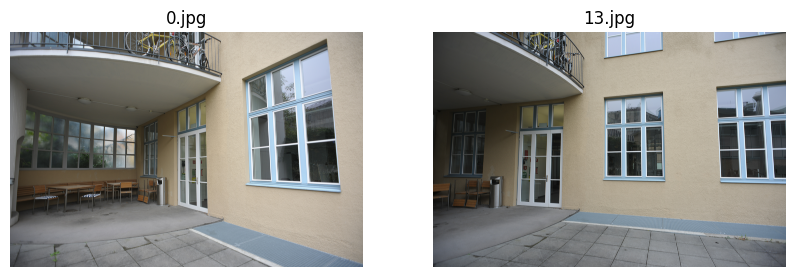

In [17]:
# match keypoint index validation for a pair id
pair_id = 2147483653
img_id1, img_id2 = pair_id_to_image_ids(pair_id)
img_id1_name = disk_image_ids_to_image_names[img_id1]
img_id2_name = disk_image_ids_to_image_names[img_id2]

print(img_id1_name, img_id2_name    )
# read images
img1 = cv2.imread(f"./sample_data/preprocessed_images/{img_id1_name}")
img2 = cv2.imread(f"./sample_data/preprocessed_images/{img_id2_name}")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title(img_id1_name)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title(img_id2_name)
plt.axis("off")
plt.show()



(9346, 6) (8250, 2) (17596, 2)
(14084, 6) (9455, 2) (23539, 2)


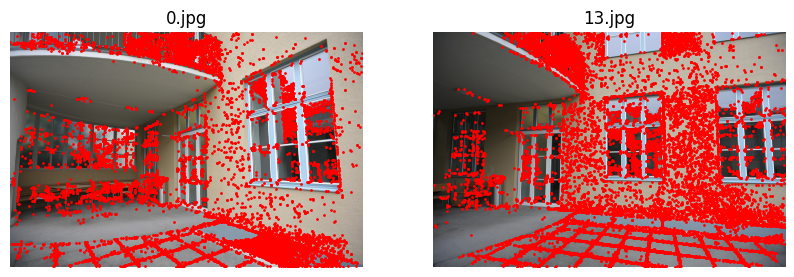

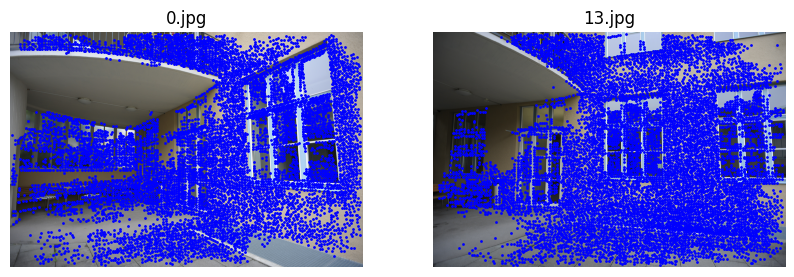

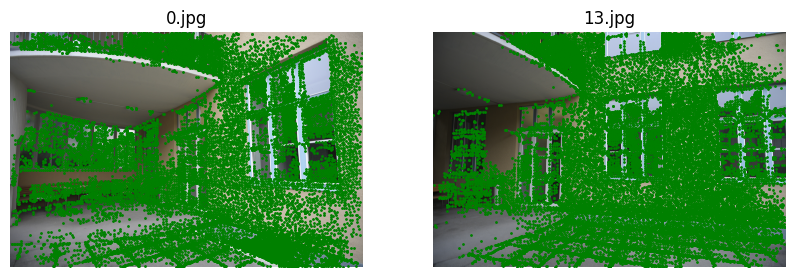

In [18]:
# get keypoint for the image
colmap_image_keypoint_img1 = colmap_keypoints[img_id1]
disk_image_keypoint_img1 = disk_keypoints[img_id1]
merged_image_keypoint_img1 = merged_keypoints[img_id1]

colmap_image_keypoint_img2 = colmap_keypoints[img_id2]
disk_image_keypoint_img2 = disk_keypoints[img_id2]
merged_image_keypoint_img2 = merged_keypoints[img_id2]

print(colmap_image_keypoint_img1.shape, disk_image_keypoint_img1.shape, merged_image_keypoint_img1.shape)
print(colmap_image_keypoint_img2.shape, disk_image_keypoint_img2.shape, merged_image_keypoint_img2.shape)

# visualize keypoint
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(colmap_image_keypoint_img1[:, 0], colmap_image_keypoint_img1[:, 1], s=1, c="r")
plt.title(img_id1_name)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(colmap_image_keypoint_img2[:, 0], colmap_image_keypoint_img2[:, 1], s=1, c="r")
plt.title(img_id2_name)
plt.axis("off")
plt.show()

# visualize keypoint
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(disk_image_keypoint_img1[:, 0], disk_image_keypoint_img1[:, 1], s=1, c="b")
plt.title(img_id1_name)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(disk_image_keypoint_img2[:, 0], disk_image_keypoint_img2[:, 1], s=1, c="b")
plt.title(img_id2_name)
plt.axis("off")
plt.show()


# visualize keypoint
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(
    merged_image_keypoint_img1[:, 0], merged_image_keypoint_img1[:, 1], s=1, c="g"
)
plt.title(img_id1_name)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(
    merged_image_keypoint_img2[:, 0], merged_image_keypoint_img2[:, 1], s=1, c="g"
)
plt.title(img_id2_name)
plt.axis("off")
plt.show()

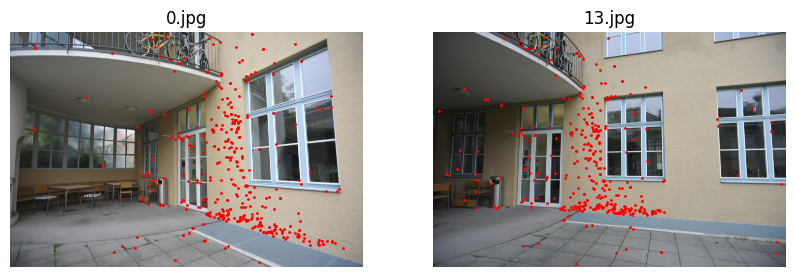

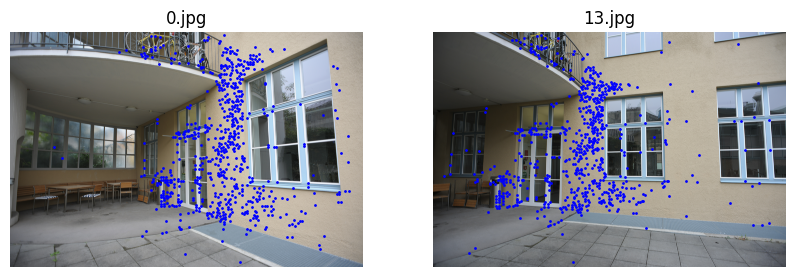

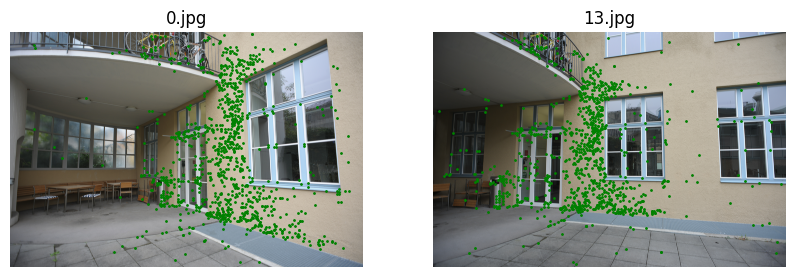

In [43]:
# get matches for the pair id
pair_id_colmap_matches = colmap_matches[pair_id]
pair_id_disk_matches = disk_matches[pair_id]
pair_id_merged_matches = merged_matches[pair_id]


# only keypoint with are in the matches
img_1_match_keypoint_index_colmap = pair_id_colmap_matches[:, 0]
img_2_match_keypoint_index_colmap = pair_id_colmap_matches[:, 1]

img_1_matched_keypoint_colmap = colmap_image_keypoint_img1[img_1_match_keypoint_index_colmap]
img_2_matched_keypoint_colmap = colmap_image_keypoint_img2[img_2_match_keypoint_index_colmap]


img_1_match_keypoint_index_disk = pair_id_disk_matches[:, 0]
img_2_match_keypoint_index_disk = pair_id_disk_matches[:, 1]

img_1_matched_keypoint_disk = disk_image_keypoint_img1[img_1_match_keypoint_index_disk]
img_2_matched_keypoint_disk = disk_image_keypoint_img2[img_2_match_keypoint_index_disk]


img_1_match_keypoint_index_merged = pair_id_merged_matches[:, 0]
img_2_match_keypoint_index_merged = pair_id_merged_matches[:, 1]

img_1_matched_keypoint_merged = merged_image_keypoint_img1[img_1_match_keypoint_index_merged]
img_2_matched_keypoint_merged = merged_image_keypoint_img2[img_2_match_keypoint_index_merged]


# visualize keypoint
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(
    img_1_matched_keypoint_colmap[:, 0], img_1_matched_keypoint_colmap[:, 1], s=1, c="r"
)
plt.title(img_id1_name)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(
    img_2_matched_keypoint_colmap[:, 0], img_2_matched_keypoint_colmap[:, 1], s=1, c="r"
)
plt.title(img_id2_name)
plt.axis("off")
plt.show()


# visualize keypoint
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(
    img_1_matched_keypoint_disk[:, 0], img_1_matched_keypoint_disk[:, 1], s=1, c="b"
)
plt.title(img_id1_name)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(
    img_2_matched_keypoint_disk[:, 0], img_2_matched_keypoint_disk[:, 1], s=1, c="b"
)
plt.title(img_id2_name)
plt.axis("off")
plt.show()


# visualize keypoint
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(
    img_1_matched_keypoint_merged[:, 0], img_1_matched_keypoint_merged[:, 1], s=1, c="g"
)
plt.title(img_id1_name)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.scatter(
    img_2_matched_keypoint_merged[:, 0], img_2_matched_keypoint_merged[:, 1], s=1, c="g"
)
plt.title(img_id2_name)
plt.axis("off")
plt.show()


# print(pair_id_colmap_matches.shape)
# print(pair_id_disk_matches.shape)
# print(pair_id_merged_matches.shape)

In [35]:
len(img_1_match_keypoint_index_colmap)

383

In [37]:
img_1_matched_keypoint_colmap

array([[ 2.4932634e+03,  1.2542997e+02,  7.3710284e+00, -1.9748484e+00,
         1.9753456e+00,  7.3691735e+00],
       [ 2.9992363e+03,  5.4554572e+02,  2.3961772e-01, -2.9098592e+00,
         2.9105918e+00,  2.3955742e-01],
       [ 4.1198545e+03,  3.2220713e+03,  5.0899333e-01, -3.1962349e+00,
         3.1970396e+00,  5.0886524e-01],
       ...,
       [ 3.4160684e+03,  3.0212173e+03, -4.1468075e+01,  1.0348862e+01,
        -1.0351467e+01, -4.1457638e+01],
       [ 3.3122632e+03,  3.0817876e+03, -3.2640266e+01,  2.5398935e+01,
        -2.5405331e+01, -3.2632050e+01],
       [ 3.4214839e+03,  1.1178831e+03,  1.3912282e+02,  2.7181829e+01,
        -2.7188671e+01,  1.3908780e+02]], dtype=float32)

In [27]:
# data = [i+1 for i in range(10)]
# index = [3,4,6,8,9]
# values_by_index = [data[i] for i in index]
# print(data)
# print(index)
# print(values_by_index)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[3, 4, 6, 8, 9]
[4, 5, 7, 9, 10]
